# Implementation that works with hugginface models and datasets for greater reproducibility

In [1]:
import numpy as np
import torch
from datasets import load_dataset
from torch import nn
from torch.nn import functional as F
from tqdm.autonotebook import tqdm
from transformers import AutoImageProcessor, ResNetForImageClassification
from PIL import Image
import matplotlib.pyplot as plt

from src.adversarial_noise.utils import get_device


In [2]:
device = get_device()

Start using the same model and dataset as the existing example (resnet34 and tiny imagenet)

In [3]:
dataset = load_dataset("zh-plus/tiny-imagenet", trust_remote_code=False)
image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-34")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-34")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Define a test image

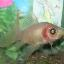

In [4]:
image = dataset["train"]["image"][0]
image


In [5]:
inputs = image_processor(image, return_tensors="pt")
with torch.no_grad():
    logits = model(**inputs).logits
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

goldfish, Carassius auratus


In [6]:
label_names = list(model.config.id2label.values())
label_names

['tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'hammerhead, hammerhead shark',
 'electric ray, crampfish, numbfish, torpedo',
 'stingray',
 'cock',
 'hen',
 'ostrich, Struthio camelus',
 'brambling, Fringilla montifringilla',
 'goldfinch, Carduelis carduelis',
 'house finch, linnet, Carpodacus mexicanus',
 'junco, snowbird',
 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 'robin, American robin, Turdus migratorius',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water ouzel, dipper',
 'kite',
 'bald eagle, American eagle, Haliaeetus leucocephalus',
 'vulture',
 'great grey owl, great gray owl, Strix nebulosa',
 'European fire salamander, Salamandra salamandra',
 'common newt, Triturus vulgaris',
 'eft',
 'spotted salamander, Ambystoma maculatum',
 'axolotl, mud puppy, Ambystoma mexicanum',
 'bullfrog, Rana catesbeiana',
 'tree frog, tree-f

In [7]:
def iterative_fast_gradient_sign_target(
    model: ResNetForImageClassification,
    imgs: torch.Tensor,
    labels: torch.Tensor,
    target_label: str,
    label_names: list,
    epsilon: float = 0.02,
    num_iter: int = 10,
    alpha: float | None = None,
) -> tuple[torch.Tensor, torch.Tensor]:
    if target_label not in label_names:
        raise ValueError(f"Target label {target_label} not found in label_names")

    target_label_idx = torch.tensor(model.config.label2id[target_label])
    target_label_idx = target_label_idx.to(imgs.device)
    target_labels = torch.full(
        (imgs.size(0),), target_label_idx, dtype=torch.long, device=imgs.device
    )
    print(target_labels)

    adv_imgs = imgs.clone()

    for _ in range(num_iter):
        adv_imgs = adv_imgs.detach().requires_grad_()
        outputs = model(adv_imgs)
        logits = outputs.logits
        preds = F.log_softmax(logits, dim=-1)
        loss = -torch.nn.CrossEntropyLoss()(preds, target_labels)
        loss.sum().backward()

        noise_grad = torch.sign(adv_imgs.grad)
        adv_imgs = adv_imgs + alpha * noise_grad

    noise_grad = adv_imgs - imgs
    predicted_label = logits.argmax(-1).item()
    print(model.config.id2label[predicted_label])
    return adv_imgs.detach(), noise_grad.detach()

In [12]:
def tensor_to_image(tensor: torch.Tensor) -> Image.Image:
    """Convert a normalized tensor to a PIL Image."""
    # Move to CPU and convert to numpy
    img_array = tensor.cpu().detach().numpy()

    # Reshape if needed (remove batch dimension if present)
    if len(img_array.shape) == 4:
        img_array = img_array[0]

    # Denormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_array = std[:, None, None] * img_array + mean[:, None, None]

    # Clip values to valid range
    img_array = np.clip(img_array, 0, 1)

    # Convert to uint8
    img_array = (img_array * 255).astype(np.uint8)

    # Transpose from (C, H, W) to (H, W, C)
    img_array = np.transpose(img_array, (1, 2, 0))

    # Convert to PIL Image
    return Image.fromarray(img_array)

In [16]:
def plot_adversarial_results(
    original_img: torch.Tensor,
    adv_img: torch.Tensor,
    noise_grad: torch.Tensor,
    model: ResNetForImageClassification,
    device: torch.device,
) -> None:
    """
    Plot adversarial attack results using matplotlib.

    Args:
        original_img: Original input image tensor
        adv_img: Adversarial image tensor
        noise_grad: Noise gradient tensor
        model: The model to get predictions from
        device: The device to run predictions on
    """

    # Create figure and axes with larger size
    fig = plt.figure(figsize=(25, 8))
    gs = fig.add_gridspec(1, 4, width_ratios=[1.2, 1.2, 1.2, 2])

    # Convert tensors to images
    orig_img = tensor_to_image(original_img)
    adv_img_pil = tensor_to_image(adv_img)
    noise_img = tensor_to_image(noise_grad)

    ax1 = fig.add_subplot(gs[0])
    ax1.imshow(orig_img)
    ax1.set_title("Original", fontsize=12, pad=10)
    ax1.axis("off")

    ax2 = fig.add_subplot(gs[1])
    ax2.imshow(adv_img_pil)
    ax2.set_title("Adversarial", fontsize=12, pad=10)
    ax2.axis("off")

    ax3 = fig.add_subplot(gs[2])
    ax3.imshow(noise_img)
    ax3.set_title("Noise", fontsize=12, pad=10)
    ax3.axis("off")

    # Get model predictions
    with torch.no_grad():
        logits = model(adv_img.to(device)).logits
        probabilities = torch.nn.functional.softmax(logits, dim=-1)[0]
        top_probs, top_indices = torch.topk(probabilities, k=10)

        # Get labels and probabilities
        labels = [model.config.id2label[idx.item()] for idx in top_indices]
        probs = [prob.item() * 100 for prob in top_probs]

    # Plot bar chart
    ax4 = fig.add_subplot(gs[3])
    bars = ax4.barh(range(len(probs)), probs)
    ax4.set_yticks(range(len(labels)))
    ax4.set_yticklabels(labels)
    ax4.set_xlabel("Probability (%)")
    ax4.set_title("Top 10 Predictions")

    # Add percentage labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax4.text(
            width + 1,
            bar.get_y() + bar.get_height() / 2,
            f"{probs[i]:.1f}%",
            va="center",
        )

    # Adjust layout
    plt.suptitle("Adversarial Attack Results", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

In [8]:
pretrained_model = model.to(device)
exmp_batch = inputs["pixel_values"].to(device)

label_names = list(model.config.id2label.values())

adv_imgs, noise_grad = iterative_fast_gradient_sign_target(
    model=pretrained_model,
    imgs=exmp_batch,
    target_label="eft",
    labels=None,
    label_names=label_names,
    # epsilon=0.02,
    alpha=0.002,
    num_iter=10,
)

tensor([27], device='mps:0')
eft


In [9]:
with torch.no_grad():
    logits = model(adv_imgs.to(device)).logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)[0]

    # Get top 10 predictions
    top_probs, top_indices = torch.topk(probabilities, k=10)

    print("Top 10 predictions:")
    print("-" * 50)
    for prob, idx in zip(top_probs, top_indices):
        label = model.config.id2label[idx.item()]
        print(f"{label:<30} {prob.item() * 100:>6.2f}%")

Top 10 predictions:
--------------------------------------------------
eft                             98.72%
common newt, Triturus vulgaris   0.61%
goldfish, Carassius auratus      0.14%
axolotl, mud puppy, Ambystoma mexicanum   0.06%
spotted salamander, Ambystoma maculatum   0.05%
mongoose                         0.02%
tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui   0.01%
ringlet, ringlet butterfly       0.01%
European fire salamander, Salamandra salamandra   0.01%
Windsor tie                      0.01%


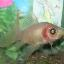

In [13]:
image

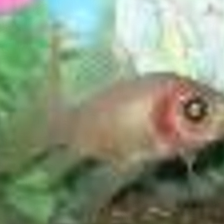

In [14]:
tensor_to_image(adv_imgs)

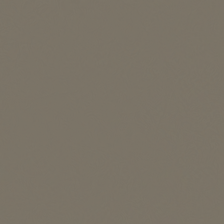

In [15]:
tensor_to_image(noise_grad)

In [10]:
pretrained_model = model.to(device)
exmp_batch = inputs["pixel_values"].to(device)

label_names = list(model.config.id2label.values())

adv_imgs, noise_grad = iterative_fast_gradient_sign_target(
    model=pretrained_model,
    imgs=exmp_batch,
    target_label="ostrich, Struthio camelus",
    labels=None,
    label_names=label_names,
    # epsilon=0.02,
    alpha=0.002,
    num_iter=10,
)

tensor([9], device='mps:0')
ostrich, Struthio camelus


In [11]:
with torch.no_grad():
    logits = model(adv_imgs.to(device)).logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)[0]

    # Get top 10 predictions
    top_probs, top_indices = torch.topk(probabilities, k=10)

    print("Top 10 predictions:")
    print("-" * 50)
    for prob, idx in zip(top_probs, top_indices):
        label = model.config.id2label[idx.item()]
        print(f"{label:<30} {prob.item() * 100:>6.2f}%")

Top 10 predictions:
--------------------------------------------------
ostrich, Struthio camelus       95.32%
patas, hussar monkey, Erythrocebus patas   0.78%
macaque                          0.68%
crane                            0.51%
baboon                           0.31%
hen                              0.24%
black stork, Ciconia nigra       0.17%
vulture                          0.09%
marmoset                         0.09%
hornbill                         0.08%


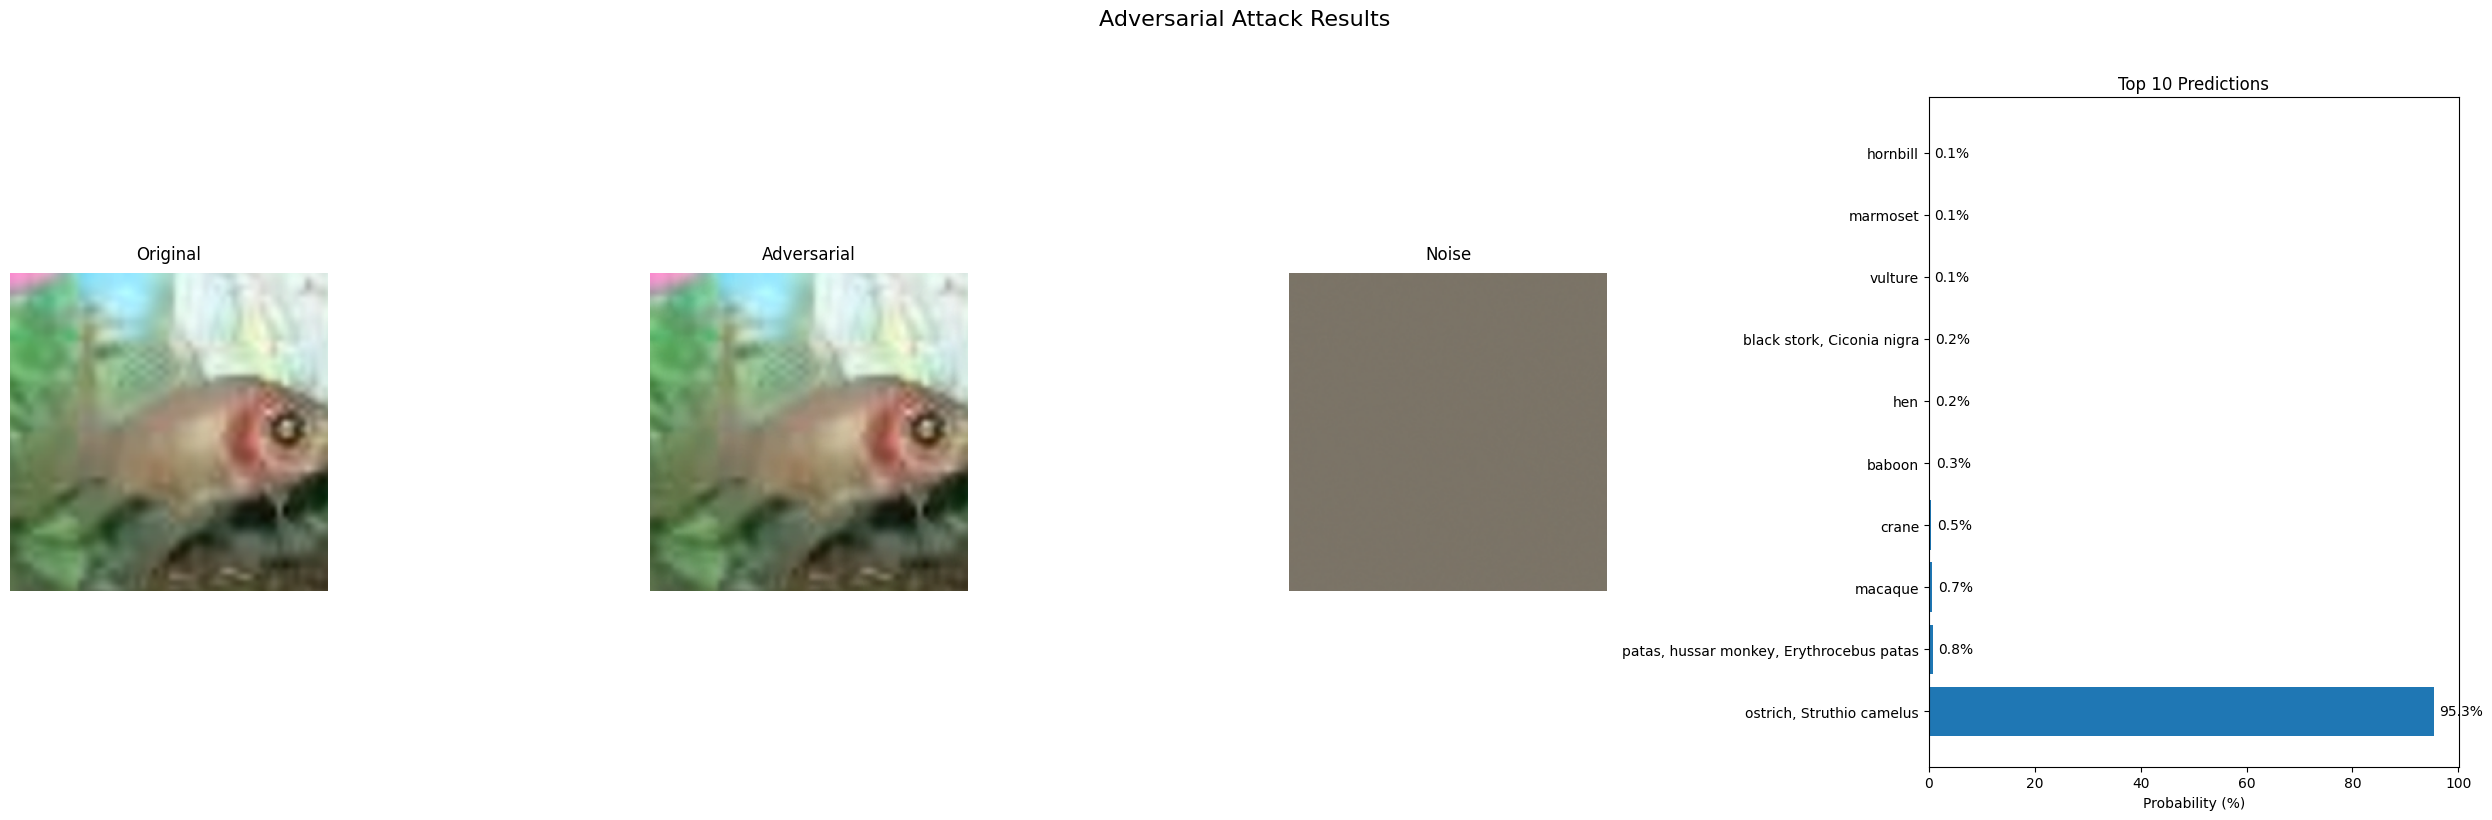

In [17]:
plot_adversarial_results(
    original_img=exmp_batch,
    adv_img=adv_imgs,
    noise_grad=noise_grad,
    model=model,
    device=device,
)